### Ejericicios de A/B Testing

**Ejercicio 1:**

Supongamos que estamos realizando un experimento para determinar si un nuevo diseño de anuncio (test group "ad") tiene un impacto significativo en la tasa de conversión en comparación con el diseño de anuncio anterior (test group "psa").

Objetivo del ejercicio: Comparar las tasas de conversión entre los grupos de prueba "ad" y "psa" para determinar si el nuevo diseño de anuncio es más efectivo en la conversión de usuarios.

In [18]:
#Importo librerías
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import scipy.stats as st
from scipy.stats import shapiro, poisson, chisquare, expon, kstest

import warnings
warnings.filterwarnings("ignore")

#Configuro la visualización del DF.
pd.set_option('display.max_columns', None) 

Pasos que debemos seguir:

- Preparación de los datos: Asegúrate de que los datos estén limpios y listos para el análisis. Esto incluye la eliminación de datos faltantes y la verificación de la coherencia de los datos.

In [19]:
#Abro el csv.
df=pd.read_csv('marketing_AB.csv', index_col=0)
df.head()

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


In [20]:
#Cambio el nombre de las columnas
columnas = [col.lower().replace(" ", "_") for col in df.columns]
df.columns = columnas

In [21]:
#Cambio la tipología de la columna 'converted' de booleano a object.
df['converted'] = df['converted'].astype('object')
df['converted'] = df['converted'].replace({True: 'yes', False: 'no'})

In [22]:
#Imprimo la info del DF.
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        588101 non-null  int64 
 1   test_group     588101 non-null  object
 2   converted      588101 non-null  object
 3   total_ads      588101 non-null  int64 
 4   most_ads_day   588101 non-null  object
 5   most_ads_hour  588101 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 31.4+ MB


In [23]:
#Busco valores duplicados dentro de las columnas.
for columna in df.columns:
    duplicados= df[columna].duplicated().sum()

    print(f'La columna {columna.upper()} tiene {duplicados} valores duplicados')

#Los duplicados tienen sentido así que no los elimino.


La columna USER_ID tiene 0 valores duplicados
La columna TEST_GROUP tiene 588099 valores duplicados
La columna CONVERTED tiene 588099 valores duplicados
La columna TOTAL_ADS tiene 587294 valores duplicados
La columna MOST_ADS_DAY tiene 588094 valores duplicados
La columna MOST_ADS_HOUR tiene 588077 valores duplicados


### **Observaciones:**
No hago nada con los datos duplicados ya que en el contexto del análisis tienen sentido que existan datos repetidos en estas cinco columnas del DataFrame.

In [24]:
#Busco los principales estadísticos de las columnas numéricas.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,588101.0,1.310692e+06,202225.983128,900000.0,1143190.0,1313725.0,1484088.0,1654483.0
total_ads,588101.0,2.482088e+01,43.715181,1.0,4.0,13.0,27.0,2065.0
most_ads_hour,588101.0,1.446906e+01,4.834634,0.0,11.0,14.0,18.0,23.0


In [25]:
#Busco los principales estádisticos para las columnas categóricas.
df.describe(include='O').T

,count,unique,top,freq
test_group,588101,2,ad,564577
converted,588101,2,no,573258
most_ads_day,588101,7,Friday,92608


In [26]:
#Busco en la columna 'test_group' los valores únicos para encontrar a los miembros de cada grupo de control.
df['test_group'].value_counts()

test_group
ad     564577
psa     23524
Name: count, dtype: int64

In [27]:
#Creo una tabla de contingencia para ver la relación entre las categorías de las dos variables categóricas.
tabla_contingencia = pd.crosstab(df['test_group'], df['converted'])
tabla_contingencia

converted,no,yes
test_group,,
ad,550154,14423
psa,23104,420


### **Observaciones:**
- En la tabla de correlación ya puedo ver que hay una diferencia significativa entre los clientes que han comprado y los que no, siendo muchos más los clientes que lo han hecho tras ver el nuevo anuncio. Aunque también es significativo el número de clientes que no lo ha hecho.
- Contrasto los datos de forma visual creando un gráfico de barras.

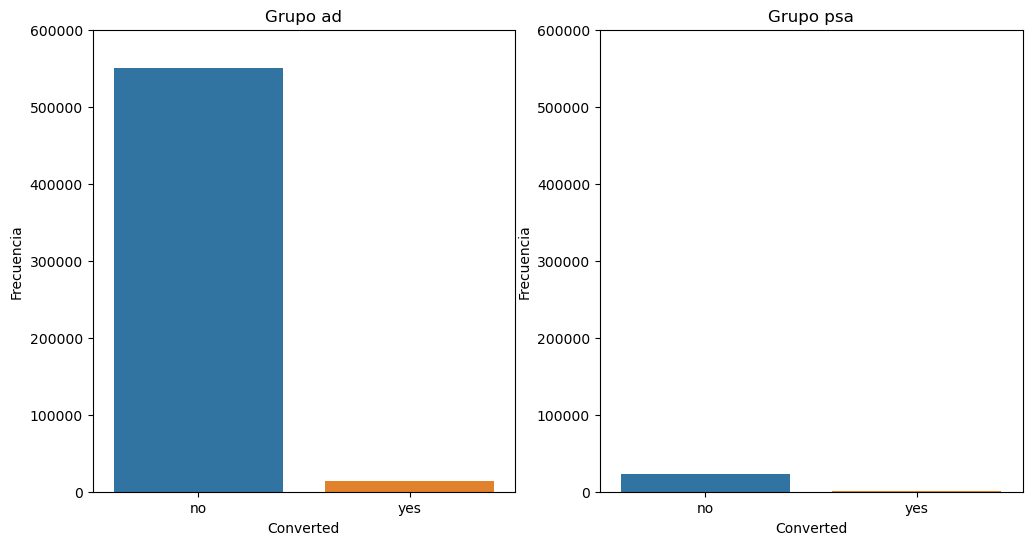

In [28]:
#Creo un gráfico para representar visualmente esta relación entre los dos conjuntos de datos.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.barplot(x=tabla_contingencia.columns, y=tabla_contingencia.loc['ad'], ax=axes[0])
axes[0].set_title('Grupo ad')
axes[0].set_xlabel('Converted')
axes[0].set_ylabel('Frecuencia')
axes[0].set_ylim(0, 600000);

# Gráfico de barras para 'psa'
sns.barplot(x=tabla_contingencia.columns, y=tabla_contingencia.loc['psa'], ax=axes[1])
axes[1].set_title('Grupo psa')
axes[1].set_xlabel('Converted')
axes[1].set_ylabel('Frecuencia')
axes[1].set_ylim(0, 600000);


In [29]:
#Creo dos columnas nuevas en el DF con los datos de los usuarios convertidos de cada grupo, cambiando el tipo de dato de las columnas, para que sea interger.
df['conversiones_ad'] = ((df['test_group'] == 'ad') & (df['converted'] == 'yes')).astype(int)
df['conversiones_psa'] = ((df['test_group'] == 'psa') & (df['converted'] == 'yes')).astype(int)

#Hago el de Shapiro-Wilk para normalidad.
statistic, p_value_ad = stats.shapiro(df['conversiones_ad'])
if p_value_ad > 0.05:
    print(f"Para la columna 'conversiones_ad', los datos siguen una distribución normal (p-value: {p_value_ad}).")
else:
    print(f"Para la columna 'conversiones_ad', los datos no siguen una distribución normal (p-value: {p_value_ad}).")

print('...................................................................')

statistic, p_value_psa = stats.shapiro(df['conversiones_psa'])
if p_value_psa > 0.05:
    print(f"Para la columna 'conversiones_psa', los datos siguen una distribución normal (p-value: {p_value_psa}).")
else:
    print(f"Para la columna 'conversiones_psa', los datos no siguen una distribución normal (p-value: {p_value_psa}).")

Para la columna 'conversiones_ad', los datos no siguen una distribución normal (p-value: 0.0).
...................................................................
Para la columna 'conversiones_psa', los datos no siguen una distribución normal (p-value: 0.0).


In [30]:
#Compruebo la homogeneidad de las variancias.
#Filtro los datos de los dos grupos
conversiones_ad = df[df['test_group'] == 'ad']['conversiones_ad']
conversiones_psa = df[df['test_group'] == 'psa']['conversiones_psa']

# Realizar el test de Levene para verificar la homogeneidad de las varianzas
statistic, p_value = stats.levene(conversiones_ad, conversiones_psa)

# Imprimir los resultados
if p_value > 0.05:
    print(f"Las varianzas son homogéneas (p-value: {p_value}).")
else:
    print(f"Las varianzas no son homogéneas (p-value: {p_value}).")

Las varianzas no son homogéneas (p-value: 1.703305262368155e-13).


- Definición de las hipótesis: Plantea una hipótesis nula (H0) y una hipótesis alternativa (H1) para el experimento (en este caso os las damos definidas):

    - Hipótesis nula (H0): No hay diferencia significativa en la tasa de conversión entre los grupos de prueba "ad" y "psa".

    - Hipótesis alternativa (H1): Existe una diferencia significativa en la tasa de conversión entre los grupos de prueba "ad" y "psa".

- Cálculo de la tasa de conversión: Calcula la tasa de conversión para cada grupo:

    - Para el grupo "ad", la tasa de conversión es el número de usuarios convertidos dividido por el número total de usuarios en ese grupo.

    - Para el grupo "psa", realiza el mismo cálculo.

In [31]:
#Recupero los datos de la tabla de contingencia para calcular la tasa de conversión
tasa_conversion_ad= 14423/(550154 + 14423)
tasa_conversion_psa= 420/(23104+420)

print(f'La tasa de conversión del grupo ad es de {tasa_conversion_ad}')
print(f'La tasa de conversión del grupo psa es de {tasa_conversion_ad}')


La tasa de conversión del grupo ad es de 0.025546559636683747
La tasa de conversión del grupo psa es de 0.025546559636683747


### **Observaciones:** 
Observo que los resultados de la tasa de conversión son los mismos que la media de cada grupo que se ha convertido en cliente.

- Prueba de hipótesis: Utiliza una prueba estadística, como la prueba t de Student o la prueba chi-cuadrado, para comparar las tasas de conversión entre los grupos "ad" y "psa".

In [32]:
#Importo la librería de Mann Whitney.
from scipy.stats import mannwhitneyu

#Uso los datos de la conversión y no de la tasa de conversión ya que el test de Mann-Whitney U se aplica directamente a las series de datos binarios que indican si hubo conversión o no en cada grupo. 
conversiones_ad = df[df['test_group'] == 'ad']['conversiones_ad']
conversiones_psa = df[df['test_group'] == 'psa']['conversiones_psa']

#Realizo el test de Mann Whitney para comparar las tasas de conversión porque las distribuciones no son normales y las variancias no son homogéneas.
statistic, p_value = mannwhitneyu(conversiones_ad, conversiones_psa)

print(f'El valor del p_value es de {p_value}')


El valor del p_value es de 1.7053617930171878e-13


- Análisis de resultados:

    - Si el valor p es menor que un umbral predefinido (por ejemplo, 0.05), rechazamos la hipótesis nula y concluimos que hay una diferencia significativa en las tasas de conversión entre los grupos.

    - Si el valor p es mayor que el umbral, no podemos rechazar la hipótesis nula y concluimos que no hay evidencia suficiente para afirmar que hay una diferencia significativa.

In [33]:
if p_value < 0.05:
    print("Rechazamos la hipótesis nula.")
    print(f"Hay una diferencia significativa en las tasas de conversión entre los grupos (p-value: {p_value}).")
else:
    print("No podemos rechazar la hipótesis nula.")
    print(f"No hay una diferencia significativa en las tasas de conversión entre los grupos (p-value: {p_value}).")

Rechazamos la hipótesis nula.
Hay una diferencia significativa en las tasas de conversión entre los grupos (p-value: 1.7053617930171878e-13).


- Conclusiones y recomendaciones: Basándote en los resultados de la prueba de hipótesis, llega a una conclusión sobre si el nuevo diseño de anuncio es más efectivo en la conversión de usuarios que el diseño anterior. Si es así, puedes hacer recomendaciones basadas en estos hallazgos.

### **Conclusiones** 
Concluimos que el nuevo diseño de anuncio logra una conversión significativamente mayor de usuarios, por lo que resulta más efectivo.

**Ejercicio 2:**

En este caso, vamos a realizar un experimento para comparar la cantidad promedio de anuncios vistos por los usuarios en los grupos "ad" y "psa" y determinar si hay una diferencia significativa entre ellos.

Objetivo del experimento: Comparar la cantidad promedio de anuncios vistos por usuario entre los grupos de prueba "ad" y "psa" para determinar si el tipo de anuncio afecta la cantidad de anuncios que los usuarios ven.

- Preparación de los datos: Asegúrate de que los datos estén limpios y listos para el análisis. Esto incluye la eliminación de datos faltantes y la verificación de la coherencia de los datos.

In [34]:
#Filtro los datos y los agrupo para crear los dos grupos de muestras.
total_anuncios_ad = df[df['test_group'] == 'ad']['total_ads']
total_anuncios_psa = df[df['test_group'] == 'psa']['total_ads']

- Hipótesis: Plantea una hipótesis nula (H0) y una hipótesis alternativa (H1) para el experimento. En este caso, las deberéis plantear vosotras

### Planteamiento de hipótesis:
**Hipótesis Nula (H0):** No hay diferencia significativa en la cantidad de anuncios vistos entre los grupos de prueba "ad" y "psa".

**Hipótesis alternativa (H1):** Existe una diferencia significativa en la cantidad de anuncios vistos entre los grupos de prueba "ad" y "psa".

### **Observaciones:**
Para saber qué test de hipótesis he de realizar, compruebo si las distribuciones son normales o no.

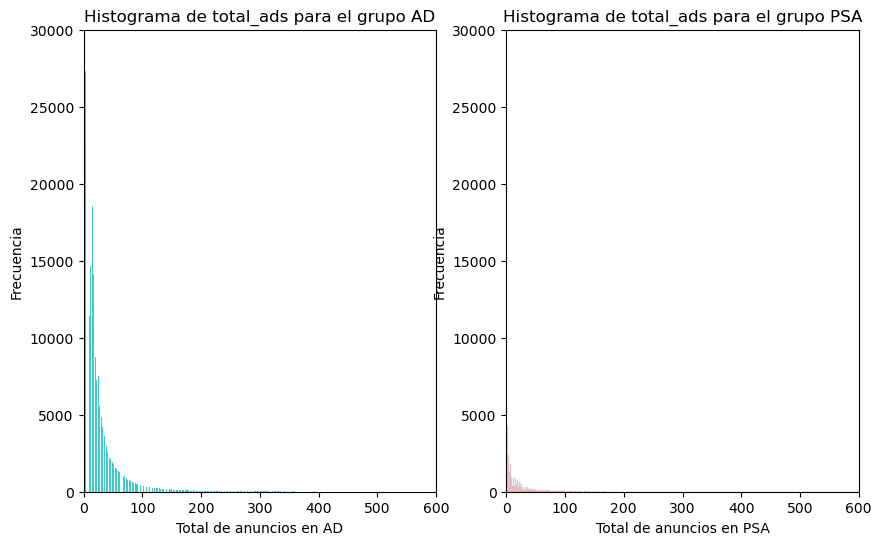

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

df_ad = df[df['test_group'] == 'ad']
df_psa= df[df['test_group'] == 'psa']

#Creo el histograma para 'total_ads' en el grupo 'ad'
sns.histplot(x='total_ads', data=df_ad, color='c', ax=axes[0])
axes[0].set_title('Histograma de total_ads para el grupo AD')
axes[0].set_xlabel('Total de anuncios en AD')
axes[0].set_ylabel('Frecuencia')

#Creo el histograma para 'total_ads' en el grupo 'psa'
sns.histplot(x='total_ads', data=df_psa, color='pink', ax=axes[1])
axes[1].set_title('Histograma de total_ads para el grupo PSA')
axes[1].set_xlabel('Total de anuncios en PSA')
axes[1].set_ylabel('Frecuencia')

axes[0].set_xlim(0, 600)  # Ajustar límites de x para AD
axes[0].set_ylim(0, 30000)  # Ajustar límites de y para AD
axes[1].set_xlim(0, 600)  # Ajustar límites de x para PSA
axes[1].set_ylim(0, 30000);

### **Observaciones:**
Ya observo que la distribución no es normal pero lo voy a comprobar con un test de shapiro.

In [37]:
#Filtro los datos del total de anuncios visto por cada grupo.
total_anuncios_ad = df.loc[df['test_group'] == 'ad', 'total_ads']
total_anuncios_psa = df.loc[df['test_group'] == 'psa', 'total_ads']

#Hago la prueba de Shapiro-Wilk para normalidad
statistic, p_value_ad = stats.shapiro(total_anuncios_ad)
if p_value_ad > 0.05:
    print(f"Para la columna 'total_anuncios_ad', los datos siguen una distribución normal p-value: {p_value_ad:.5f}")
else:
    print(f"Para la columna 'total_anuncios_ad', los datos no siguen una distribución normal, p-value: {p_value_ad:.5f}")

print('...................................................................')

statistic, p_value_psa = stats.shapiro(total_anuncios_psa)
if p_value_psa > 0.05:
    print(f"Para la columna 'total_anuncios_psa', los datos siguen una distribución normal, p-value: {p_value_ad:.5f}")
else:
    print(f"Para la columna 'total_anuncios_psa', los datos no siguen una distribución normal, p-value: {p_value_psa:.5f}")

Para la columna 'total_anuncios_ad', los datos no siguen una distribución normal, p-value: 0.00000
...................................................................
Para la columna 'total_anuncios_psa', los datos no siguen una distribución normal, p-value: 0.00000


In [38]:
#Compruebo la homogeneidad de las variancias.
#Filtro los datos del total de anuncios visto por cada grupo.
total_anuncios_ad = df.loc[df['test_group'] == 'ad', 'total_ads']
total_anuncios_psa = df.loc[df['test_group'] == 'psa', 'total_ads']

# Realizar el test de Levene para verificar la homogeneidad de las varianzas
statistic, p_value = stats.levene(total_anuncios_ad, total_anuncios_psa)

# Imprimir los resultados
if p_value > 0.05:
    print(f"Las varianzas son homogéneas, p-value: {p_value}")
else:
    print(f"Las varianzas no son homogéneas, p-value: {p_value}")

Las varianzas no son homogéneas, p-value: 0.020628382759511198


### Prueba de hipótesis: 
Como las variancias no son homogéneas y la distribución tampoco es normal, utilizo la prueba de Mann Whitney para comparar la cantidad promedio de anuncios vistos por usuario entre los grupos "ad" y "psa". Esto te permitirá determinar si hay una diferencia significativa entre los dos grupos.

In [39]:
#Uso los datos filtrados.
total_anuncios_ad = df.loc[df['test_group'] == 'ad', 'total_ads']
total_anuncios_psa = df.loc[df['test_group'] == 'psa', 'total_ads']

#Realizo el test de Mann Whitney para comparar las tasas de conversión porque las distribuciones no son normales y las variancias no son homogéneas.
statistic, p_value = mannwhitneyu(conversiones_ad, conversiones_psa)

print(f'El valor del p_value es de {p_value}')

El valor del p_value es de 1.7053617930171878e-13


- Análisis de resultados:

    - Si el valor p (p-value) es menor que un umbral predefinido (por ejemplo, 0.05), rechazamos la hipótesis nula y concluimos que hay una diferencia significativa en la cantidad promedio de anuncios vistos por usuario entre los grupos.

    - Si el valor p es mayor que el umbral, no podemos rechazar la hipótesis nula y concluimos que no hay evidencia suficiente para afirmar que hay una diferencia significativa.



In [40]:
#Alfa
alfa=0.05
#Comparo el valor p con el nivel de significancia.
if p_value > alfa:
    print("No podemos rechazar la hipótesis nula.")
    print("No existe una diferencia significativa en el promedio de anuncios visto entre los grupos 'ad' y 'psa'.")
else:
    print("Rechazamos la hipótesis nula.")
    print("Existe una diferencia significativa en el promedio de anuncios visto entre los grupos 'ad' y 'psa'.")

Rechazamos la hipótesis nula.
Existe una diferencia significativa en el promedio de anuncios visto entre los grupos 'ad' y 'psa'.


- Conclusiones y recomendaciones: Basándote en los resultados de la prueba de hipótesis, llega a una conclusión sobre si el tipo de anuncio (ad o psa) tiene un impacto significativo en la cantidad promedio de anuncios vistos por usuario. Si es así, puedes hacer recomendaciones basadas en estos hallazgos.

## **Conclusiones** 
Para saber si este dato es relevante o no, nos falta conocer la frecuencia con la que se publicó uno u otro anuncio. Si ambos se publicaron en las mismas franjas horarias el mismo número de veces, la hipótesis nula tendría más sentido. En caso contrario, la estretegía de medios debería retrabajarse para que el anuncio con mayor frecuencia de insercciones tuviera una diferencia significativa frente al otro.